# コモディティ

In [9]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import yfinance as yf


In [59]:
# 純パラジウム上場信託
yf_ticker = yf.Ticker("1543.T")
historical_data = yf_ticker.history(period="max")["Close"]
historical_data.index
df_1543 = (
    pl.DataFrame({
        "date": pl.Series(historical_data.index),
        "close": pl.Series(historical_data.values)
    })
    .with_columns(pl.col("date").cast(pl.Date))
)

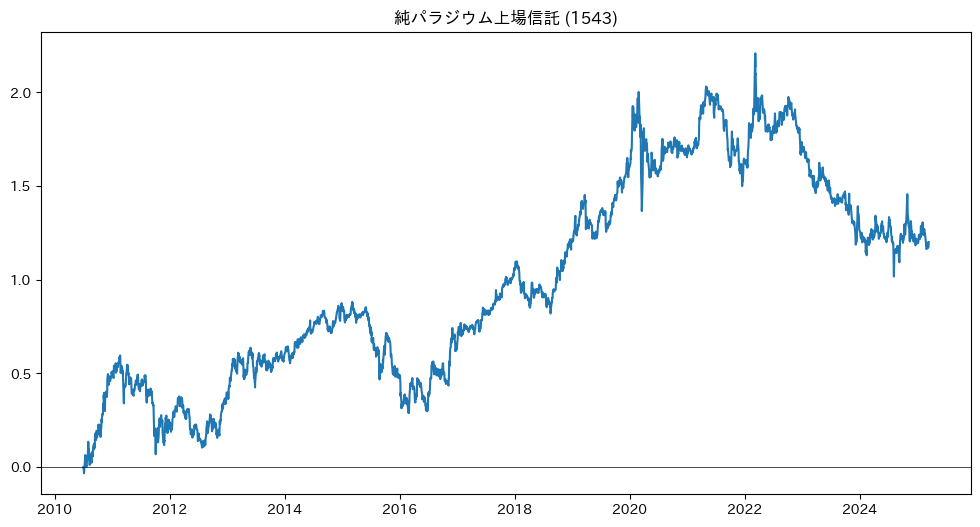

In [60]:
df_1543 = (
    df_1543
    .with_columns(pl.col("close").log().alias("log_close"))
    .with_columns(pl.col("log_close").diff().alias("log_return"))
    .with_columns((pl.col("log_close") - pl.col("log_close").first()).alias("log_cum_return"))
)

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("純パラジウム上場信託 (1543)")
ax.plot(df_1543["date"], df_1543["log_cum_return"])
ax.axhline(0, color="black", linewidth=0.5)

In [299]:
v_last = np.exp(df_1543['log_close'].last()) - 1
v_first = np.exp(df_1543['log_close'].first()) - 1
n_years = len(df_1543) / 252
cagr = (v_last / v_first) ** (1 / n_years) - 1
print(f'純パラジウム上場信託 (1543) のCAGR: {cagr:.2%}')

log_return = df_1543['log_return'].drop_nulls().to_numpy()
volatility_daily = np.std(log_return)
volatility = volatility_daily * np.sqrt(252)
print(f'純パラジウム上場信託 (1543) のボラティリティ: {volatility:.2%}')

sharp_ratio = cagr / volatility
print(f'純パラジウム上場信託 (1543) のシャープレシオ: {sharp_ratio:.2f}')

純パラジウム上場信託 (1543) のCAGR: 8.73%
純パラジウム上場信託 (1543) のボラティリティ: 31.54%
純パラジウム上場信託 (1543) のシャープレシオ: 0.28


In [ ]:
# 金
yf_ticker = yf.Ticker("GLD")
historical_data = yf_ticker.history(period="max")["Close"]
df_gld = (
    pl.DataFrame({
        "date": pl.Series(historical_data.index),
        "close": pl.Series(historical_data.values)
    })
    .with_columns(pl.col("date").cast(pl.Date))
    .with_columns(pl.col("close").log().alias("log_close"))
    .with_columns(pl.col("log_close").diff().alias("log_return"))
    .with_columns((pl.col("log_close") - pl.col("log_close").first()).alias("log_cum_return"))
)

v_last = np.exp(df_gld['log_close'].last()) - 1
v_first = np.exp(df_gld['log_close'].first()) - 1
n_years = len(df_gld) / 252
cagr = (v_last / v_first) ** (1 / n_years) - 1
print(f'金 (GLD) のCAGR: {cagr:.2%}')

金 (GLD) のCAGR: 9.52%


In [84]:
df = (
    df_1543
    .join(df_gld, on="date", how="inner")
    .rename({
        "log_return": "1543",
        "log_return_right": "GLD"
    })
    .drop("close", "log_close", "log_cum_return", "close_right", "log_close_right", "log_cum_return_right")
    .drop_nulls()
    .drop("date")
)

weights = np.array([0.5, 0.5])
cov_matrix = np.cov(df, rowvar=False)
sigma_p = np.sqrt(weights.T @ cov_matrix @ weights) * np.sqrt(252)
print(f'ポートフォリオの分散: {sigma_p:.2%}')

ポートフォリオの分散: 18.48%


In [284]:
yf_tickers = yf.Tickers("GLD, SLV, 1541.T, 1543.T, JPY=X")
historical_data = yf_tickers.history(period="max")["Close"]
df = (
    pl.DataFrame({
        "date": pl.Series(historical_data.index),
        "GLD": pl.Series(historical_data["GLD"].values * historical_data["JPY=X"].values),
        "SLV": pl.Series(historical_data["SLV"].values * historical_data["JPY=X"].values),
        "1541": pl.Series(historical_data["1541.T"].values), # プラチナ
        "1543": pl.Series(historical_data["1543.T"].values) # パラジウム
    })
    .with_columns(pl.col("date").cast(pl.Date))
    .drop_nans()
)

df_cum_log_return = (
    df
    .select([
        (pl.col("GLD").log() - pl.col("GLD").log().first()).alias("GLD"),
        (pl.col("SLV").log() - pl.col("SLV").log().first()).alias("SLV"),
        (pl.col("1541").log() - pl.col("1541").log().first()).alias("1541"),
        (pl.col("1543").log() - pl.col("1543").log().first()).alias("1543")
    ])
)


df_log_return = (
    df
    .select([
        pl.col("GLD").log().diff(),
        pl.col("SLV").log().diff(),
        pl.col("1541").log().diff(),
        pl.col("1543").log().diff()
    ])
    .drop_nulls()
    # .drop("date", "GLD_log_return", "SLV_log_return", "1541_log_return", "1543_log_return")
)

[*********************100%***********************]  5 of 5 completed


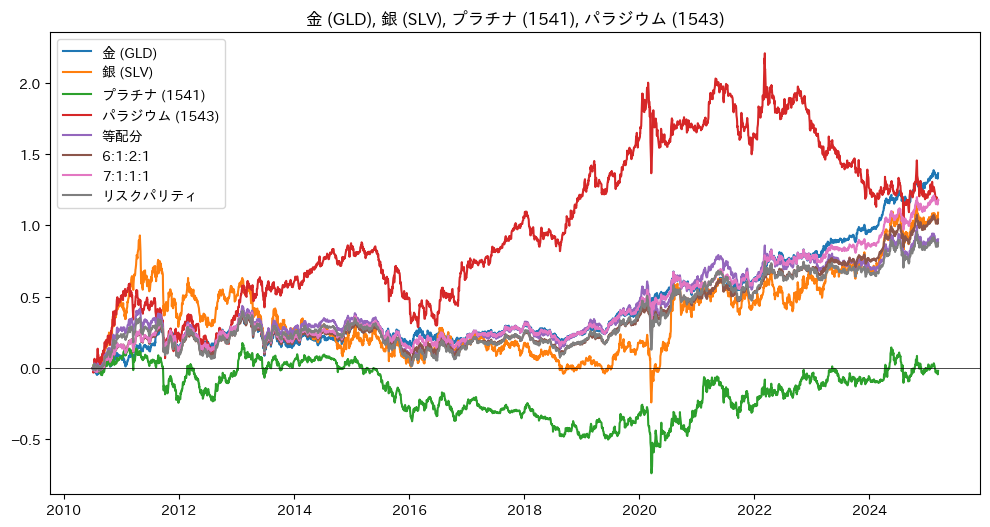

In [389]:
equal_portfolio = df_cum_log_return["GLD"] * 0.25 + df_cum_log_return["SLV"] * 0.25 + df_cum_log_return["1541"] * 0.25 + df_cum_log_return["1543"] * 0.25
rakuten_portfolio = df_cum_log_return["GLD"] * 0.6 + df_cum_log_return["SLV"] * 0.1 + df_cum_log_return["1541"] * 0.2 + df_cum_log_return["1543"] * 0.1
my_portfolio = df_cum_log_return["GLD"] * 0.7 + df_cum_log_return["SLV"] * 0.1 + df_cum_log_return["1541"] * 0.1 + df_cum_log_return["1543"] * 0.1
rp_portfolio = df_cum_log_return @ risk_parity_weights

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("金 (GLD), 銀 (SLV), プラチナ (1541), パラジウム (1543)")
ax.plot(df["date"], df_cum_log_return["GLD"], label="金 (GLD)")
ax.plot(df["date"], df_cum_log_return["SLV"], label="銀 (SLV)")
ax.plot(df["date"], df_cum_log_return["1541"], label="プラチナ (1541)")
ax.plot(df["date"], df_cum_log_return["1543"], label="パラジウム (1543)")
ax.plot(df["date"], equal_portfolio, label="等配分")
ax.plot(df['date'], rakuten_portfolio, label="6:1:2:1")
ax.plot(df['date'], my_portfolio, label="7:1:1:1")
ax.plot(df['date'], rp_portfolio, label="リスクパリティ")
ax.axhline(0, color="black", linewidth=0.5)
ax.legend()

In [297]:
v_last = df_cum_log_return['GLD'].exp().last()
v_first = df_cum_log_return['GLD'].exp().first()
n_years = len(df_cum_log_return) / 252
cagr = (v_last / v_first) ** (1 / n_years) - 1
mu = cagr

sigma = df_cum_log_return['GLD'].diff().drop_nulls().std() * np.sqrt(252)
sharp_ratio = mu / sigma
print(f'金 (GLD) の期待収益率: {mu:.2%}')
print(f'金 (GLD) のボラティリティ: {sigma:.2%}')
print(f'金 (GLD) のシャープレシオ: {sharp_ratio:.2f}')

金 (GLD) の期待収益率: 10.39%
金 (GLD) のボラティリティ: 18.42%
金 (GLD) のシャープレシオ: 0.56


In [307]:
mu_p = equal_portfolio.diff().drop_nulls().mean() * 252
v_last = equal_portfolio.exp().last()
v_first = equal_portfolio.exp().first()
n_years = len(equal_portfolio) / 252
cagr = (v_last / v_first) ** (1 / n_years) - 1

sigma_p = equal_portfolio.diff().drop_nulls().std() * np.sqrt(252)
sharp_ratio = mu_p / sigma_p
print(f'等配分ポートフォリオの期待リターン: {mu_p:.2%}')
print(f'cagr: {cagr:.2%}')
print(f'等配分ポートフォリオのボラティリティ: {sigma_p:.2%}')
print(f'等配分ポートフォリオのシャープレシオ: {sharp_ratio:.2f}')

mu_p = rakuten_portfolio.diff().drop_nulls().mean() * 252

v_last = rakuten_portfolio.exp().last()
v_first = rakuten_portfolio.exp().first()
n_years = len(rakuten_portfolio) / 252
cagr = (v_last / v_first) ** (1 / n_years) - 1

sigma_p = rakuten_portfolio.diff().drop_nulls().std() * np.sqrt(252)

sharp_ratio = mu_p / sigma_p

print(f'楽天証券ポートフォリオの期待リターン: {mu_p:.2%}')
print(f'楽天証券ポートフォリオのCAGR: {cagr:.2%}')
print(f'楽天証券ポートフォリオのボラティリティ: {sigma_p:.2%}')
print(f'楽天証券ポートフォリオのシャープレシオ: {sharp_ratio:.2f}')

等配分ポートフォリオの期待リターン: 6.53%
cagr: 6.75%
等配分ポートフォリオのボラティリティ: 18.28%
等配分ポートフォリオのシャープレシオ: 0.36
楽天証券ポートフォリオの期待リターン: 7.54%
楽天証券ポートフォリオのCAGR: 7.83%
楽天証券ポートフォリオのボラティリティ: 16.24%
楽天証券ポートフォリオのシャープレシオ: 0.46


In [266]:
weights = np.array([0.25]*4)
cov_matrix = np.cov(df_log_return, rowvar=False)
sigma_p = np.sqrt(weights.T @ cov_matrix @ weights) * np.sqrt(252)
print(f'均等加重の分散: {sigma_p:.2%}')

均等加重の分散: 17.22%


In [411]:
v_last = np.exp(df_log_return[-1].to_numpy().flatten() @ weights) - 1
n_years = len(df_log_return) / 252
mu_p = v_last ** (1 / n_years) - 1

In [412]:
weight_list = []
mu_p_list = []
sigma_p_list = []
sharp_ratio_list = []

for i in range(10000):
    weights = np.random.rand(4)
    weights /= np.sum(weights)
    v_last = np.exp(df_log_return[-1].to_numpy().flatten() @ weights) - 1
    n_years = len(df_log_return) / 252
    mu_p = v_last ** (1 / n_years) - 1
    sigma_p = np.sqrt(weights.T @ cov_matrix @ weights) * np.sqrt(252) * 100
    sharp_ratio = mu_p / sigma_p
    weight_list.append(weights)
    mu_p_list.append(mu_p)
    sigma_p_list.append(sigma_p)
    sharp_ratio_list.append(sharp_ratio)

df_random = pl.DataFrame({
    "weight": pl.Series(weight_list),
    "mu_p": pl.Series(mu_p_list),
    "sigma_p": pl.Series(sigma_p_list),
    "sharp_ratio": pl.Series(sharp_ratio_list)
})


In [413]:
def calculate_sigma(df):
    sigma_gld = np.std(df["GLD"].to_numpy()) * np.sqrt(252)
    sigma_slv = np.std(df["SLV"].to_numpy()) * np.sqrt(252)
    sigma_platina = np.std(df["1541"].to_numpy()) * np.sqrt(252)
    sigma_palladium = np.std(df["1543"].to_numpy()) * np.sqrt(252)
    return sigma_gld, sigma_slv, sigma_platina, sigma_palladium

def risk_parity(df):
    sigma_gld, sigma_slv, sigma_platina, sigma_paradium = calculate_sigma(df)
    weights = np.array([1/sigma_gld, 1/sigma_slv, 1/sigma_platina, 1/sigma_paradium])
    weights /= np.sum(weights)
    return weights

risk_parity_weights = risk_parity(df_log_return)
print(f'リスク平等配分: {weights}')

mu_rp = float(df_log_return[-1].to_numpy() @ weights) * 252
sigma_rp = np.sqrt(weights.T @ cov_matrix @ weights) * np.sqrt(252) * 100
sharp_ratio = mu_rp / sigma_rp

print(f'リスク平等ポートフォリオの期待リターン: {mu_rp:.2f}')
print(f'リスク平等ポートフォリオのボラティリティ: {sigma_rp:.2f}')
print(f'リスク平等ポートフォリオのシャープレシオ: {sharp_ratio:.2f}')


リスク平等配分: [0.09123228 0.5591047  0.27119202 0.07847099]
リスク平等ポートフォリオの期待リターン: 3.51
リスク平等ポートフォリオのボラティリティ: 21.82
リスク平等ポートフォリオのシャープレシオ: 0.16


/tmp/ipykernel_32291/1549466247.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_rp = float(df_log_return[-1].to_numpy() @ weights) * 252


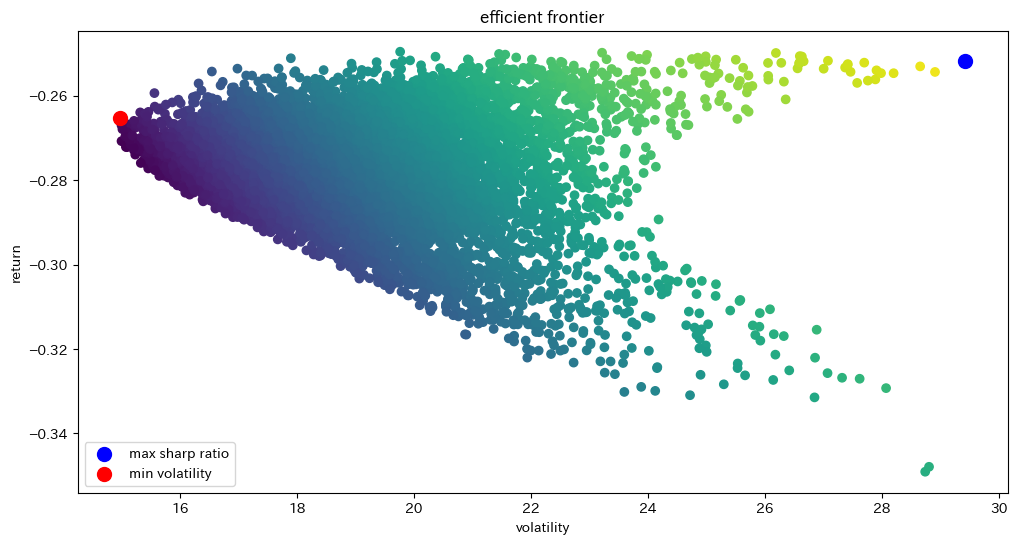

In [416]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("efficient frontier")
ax.scatter(df_random["sigma_p"], df_random["mu_p"], c=df_random["sharp_ratio"], cmap="viridis")

max_sharp_ratio = df_random["sharp_ratio"].max()
max_sharp_ratio_record = df_random.filter(pl.col("sharp_ratio") == max_sharp_ratio)
ax.scatter(max_sharp_ratio_record["sigma_p"], max_sharp_ratio_record["mu_p"], c="blue", s=100, label="max sharp ratio")

min_volatility = df_random["sigma_p"].min()
min_volatility_record = df_random.filter(pl.col("sigma_p") == min_volatility)
ax.scatter(min_volatility_record["sigma_p"], min_volatility_record["mu_p"], c="red", s=100, label="min volatility")

# ax.scatter(sigma_rp, mu_rp, c="green", s=100, label="risk parity")

ax.set_xlabel("volatility")
ax.set_ylabel("return")
ax.legend()

In [360]:
max_sharp_ratio = df_random["sharp_ratio"].max()
max_sharp_ratio_record = df_random.filter(pl.col("sharp_ratio") == max_sharp_ratio)
max_sharp_ratio_weight = max_sharp_ratio_record['weight'].to_numpy()

min_volatility = df_random["sigma_p"].min()
min_volatility_record = df_random.filter(pl.col("sigma_p") == min_volatility)
min_volatility_weight = min_volatility_record['weight'].to_numpy()

min_volatility_record

weight,mu_p,sigma_p,sharp_ratio
"array[f64, 4]",f64,f64,f64
"[0.607959, 0.00703, … 0.029415]",3.515154,14.989803,0.234503


In [362]:
max_sharp_ratio_record['weight'].to_numpy()
cov_matrix = np.cov(df_log_return, rowvar=False)
sigma_p = np.sqrt(weights.T @ cov_matrix @ weights) * np.sqrt(252)
print(f'My ポートフォリオの分散: {sigma_p:.2%}')

My ポートフォリオの分散: 21.15%


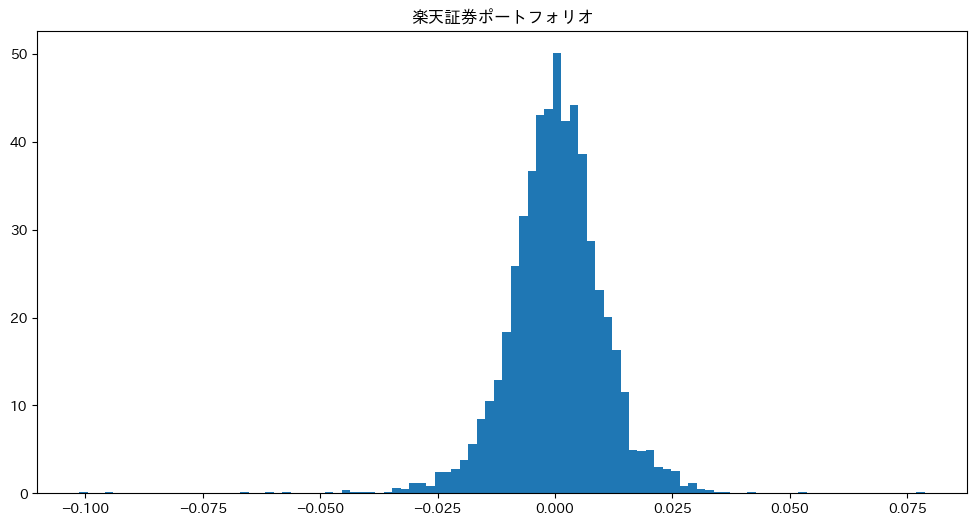

In [306]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("楽天証券ポートフォリオ")
ax.hist(rakuten_portfolio.diff(), bins=100, density=True);